In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Modul Google Drive
from google.colab import drive
# Modul Ekstraktor Zip File
import zipfile
# Modul Split Folders
import splitfolders
# Modul Operating System Portable
import os
# Modul Tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
# Modul Mathematics Task
import math
# Modul Matplotlib
import matplotlib.pyplot as plt
# Modul Scikit-learn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
# Modul Numpy
import numpy as np
# Modul Filesystem Path
import pathlib

In [ ]:
drive.mount('/content/gdrive')
!cp '/content/gdrive/MyDrive/picang-dataset-final.zip' '/content'

Mounted at /content/gdrive


In [ ]:
file_zip = '/content/picang-dataset-final.zip'
zipper = zipfile.ZipFile(file_zip, 'r')
zipper.extractall('/content/dataset')
zipper.close()

In [ ]:
base_dir = '/content/dataset'
split_dir = '/content/dataset/dataset-split'

splitfolders.ratio(base_dir, output=split_dir, seed=1337, ratio=(0.8, 0.2))

Copying files: 6012 files [00:01, 3197.83 files/s]


In [ ]:
train_dir = os.path.join(split_dir, 'train')
test_dir = os.path.join(split_dir, 'val')

In [ ]:
os.listdir(train_dir)

['Cavendish', 'Kepok', 'Raja', 'Ambon']

In [ ]:
os.listdir(test_dir)

['Cavendish', 'Kepok', 'Raja', 'Ambon']

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (224, 224), 
    batch_size = 32, 
    class_mode = 'categorical', 
    color_mode = 'rgb', 
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size = (224, 224), 
    batch_size = 32, 
    class_mode = 'categorical', 
    color_mode = 'rgb', 
    shuffle = False
)

Found 4809 images belonging to 4 classes.
Found 1203 images belonging to 4 classes.


In [ ]:
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=True, weights='imagenet')
pretrained_model.trainable = False

pretrained_model.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [ ]:
model = Sequential([
    pretrained_model, 
    layers.Dense(128, activation='relu'), 
    layers.BatchNormalization(), 
    layers.Dense(4, activation='softmax'), 
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 3,668,140
Trainable params: 128,900
Non-trainable params: 3,539,240
_________________________________________________________________


In [ ]:
def step_decay(epoch): 
  initial_lrate = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))

  return lrate

In [ ]:
class LossHistory(Callback): 
  def on_train_begin(self, logs={}): 
    self.losses = []
    self.lr = []

  def on_epoch_end(self, batch, logs={}): 
    self.losses.append(logs.get('loss'))
    self.lr.append(step_decay(len(self.losses)))

In [ ]:
lrate = LearningRateScheduler(step_decay)
loss_history = LossHistory()
callback_list = [lrate, loss_history]

In [ ]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.optimizers.Adam(learning_rate=0.0), 
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_generator, 
    validation_data = test_generator, 
    verbose = 1, 
    epochs = 100, 
    batch_size = 32, 
    callbacks = callback_list
)

Epoch 1/100
151/151 [==============================] - 58s 301ms/step - loss: 1.0211 - accuracy: 0.6284 - val_loss: 1.1250 - val_accuracy: 0.5046 - lr: 0.1000
Epoch 2/100
151/151 [==============================] - 42s 279ms/step - loss: 0.7536 - accuracy: 0.7187 - val_loss: 0.9565 - val_accuracy: 0.5752 - lr: 0.1000
Epoch 3/100
151/151 [==============================] - 42s 276ms/step - loss: 0.8160 - accuracy: 0.7012 - val_loss: 3.2746 - val_accuracy: 0.3599 - lr: 0.1000
Epoch 4/100
151/151 [==============================] - 42s 276ms/step - loss: 0.6848 - accuracy: 0.7465 - val_loss: 0.8678 - val_accuracy: 0.6858 - lr: 0.1000
Epoch 5/100
151/151 [==============================] - 42s 277ms/step - loss: 0.6857 - accuracy: 0.7430 - val_loss: 2.5818 - val_accuracy: 0.4746 - lr: 0.1000
Epoch 6/100
151/151 [==============================] - 42s 276ms/step - loss: 0.6565 - accuracy: 0.7600 - val_loss: 1.5516 - val_accuracy: 0.5669 - lr: 0.1000
Epoch 7/100
151/151 [=========================

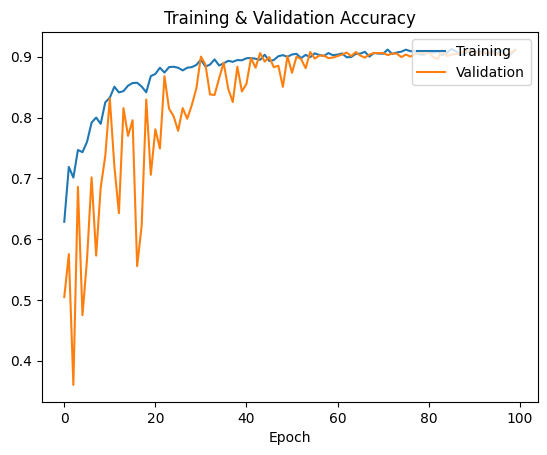

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

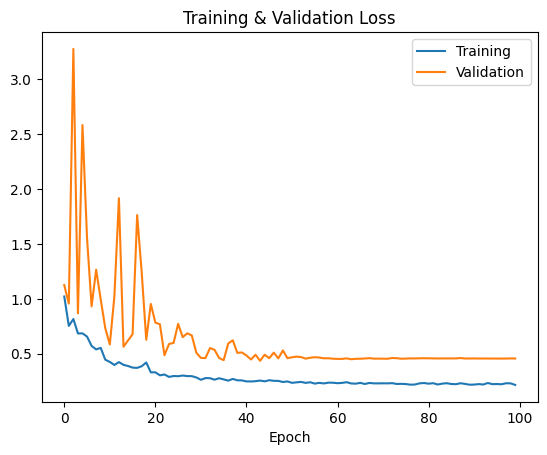

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

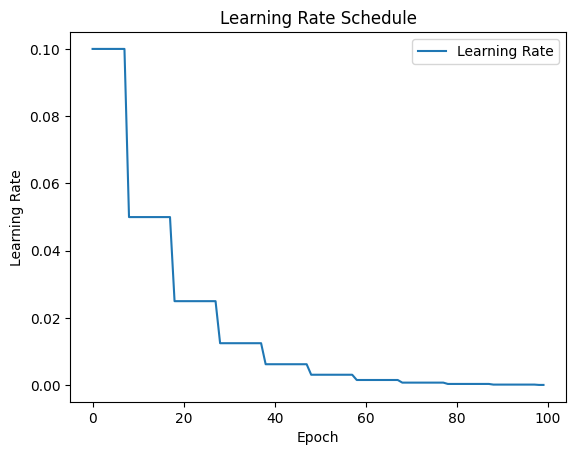

In [ ]:
plt.plot(loss_history.lr)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend(['Learning Rate'], loc='upper right')
plt.show()

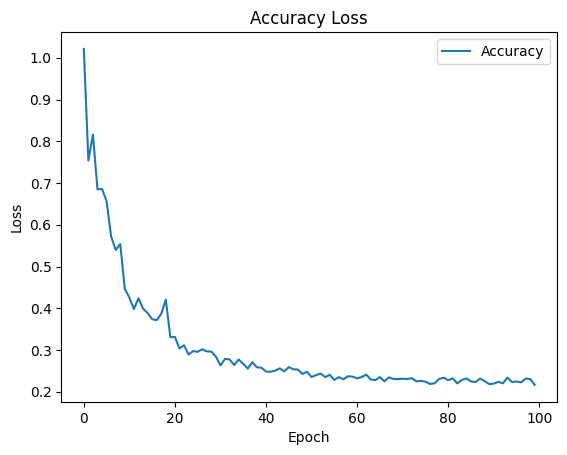

In [ ]:
plt.plot(loss_history.losses)
plt.title('Accuracy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Accuracy', 'Losses'], loc='upper right')
plt.show()

In [ ]:
y_prediction = model.predict(test_generator)
y_prediction = np.argmax(y_prediction, axis=1)

38/38 [==============================] - 8s 200ms/step


In [ ]:
print(classification_report(test_generator.classes, y_prediction, target_names=list(train_generator.class_indices.keys())))

              precision    recall  f1-score   support

       Ambon       0.88      0.93      0.90       303
   Cavendish       0.90      0.91      0.91       302
       Kepok       0.94      0.94      0.94       298
        Raja       0.92      0.87      0.90       300

    accuracy                           0.91      1203
   macro avg       0.91      0.91      0.91      1203
weighted avg       0.91      0.91      0.91      1203



<Figure size 1000x700 with 0 Axes>

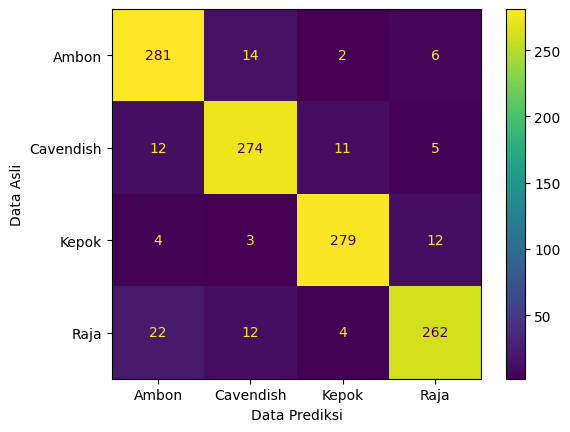

In [ ]:
cm = metrics.confusion_matrix(test_generator.classes, y_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ambon', 'Cavendish', 'Kepok', 'Raja'])
plt.figure(figsize=(10,7))
cm_display.plot()
plt.xlabel('Data Prediksi')
plt.ylabel('Data Asli')
plt.show()

In [ ]:
model.save("picang-model-without-finetune-v2.h5")

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('picang-model-without-finetune-v2.tflite')
tflite_model_file.write_bytes(tflite_model)

14506148

In [ ]:
!cp '/content/picang-model-without-finetune-v2.h5' '/content/gdrive/MyDrive'
!cp '/content/picang-model-without-finetune-v2.tflite' '/content/gdrive/MyDrive'